In [2]:
import numpy as np
import scipy.stats as st
import matplotlib.pyplot as plt
import matplotlib
import pandas as pd
import math
import time
import random
from astropy.stats import *
from scipy.integrate import simps
# plt.style.use('classic')
import json
import os
from tqdm import tqdm
from simulation_functions import *
from ast import literal_eval

                                 1.2           1.4            1.6  \
Pre-peak slope              0.302252      0.306673       0.311665   
Pre-peak slope neg          0.018967      0.019292       0.019535   
Pre-peak slope pos          0.027523      0.027627       0.027813   
Intermediate slope         -0.932582     -0.924019      -0.912893   
Intermediate slope neg      0.022533      0.021825       0.021165   
Intermediate slope pos      0.021807      0.022166       0.021668   
Post-break slope           -1.809554     -1.773270      -1.696959   
Post-break slope neg        0.057647      0.040397       0.029551   
Post-break slope pos        0.045716      0.043959       0.030812   
Peak time                   2.627985      2.420390       2.186041   
Peak time neg               0.308860      0.291895       0.248325   
Peak time pos               0.477376      0.412160       0.426941   
Break time              68681.519575  84737.860932  102955.431997   
Break time neg           9193.1557

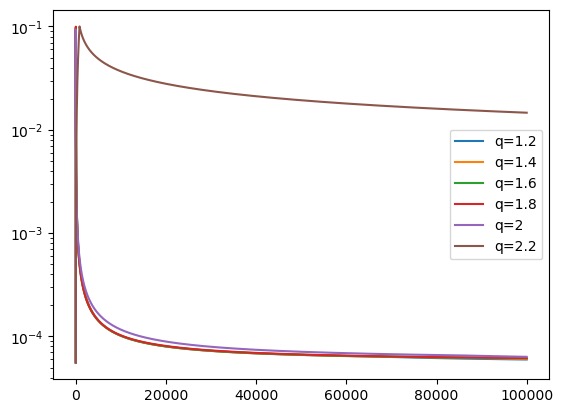

In [2]:
# GRB light curves

means = get_means_GRB()

print(means)

t_exp = 100e3

t = np.arange(0, t_exp, 1)

for i, q in enumerate([1.2, 1.4, 1.6, 1.8, 2, 2.2]):
    params = [
        means.at['Pre-peak slope', q],
        means.at['Intermediate slope', q],
        means.at['Post-break slope', q],
        means.at['Peak time', q],
        means.at['Break time', q],
    ]

    function = generate_GRB_light_curve(t, 0, 1e-1, 5.6e-5, *params)

    plt.plot(t, function, label=f'q={q}')

plt.yscale('log')
# plt.xscale('log')
plt.legend()
plt.show()

In [3]:
t, function, simulated_time, energy = simulate_FXRT(
    T_exp=30, 
    t_bin=10,
    t_0=0, 
    t_1_offset=50,
    t_2_offset=1 * 1000,
    alpha_1=-0.1,
    alpha_2=-2,
    background=5.6e-5, 
    total_counts=10000, 
    peak=1e-1,
    broken_power_law=True
)

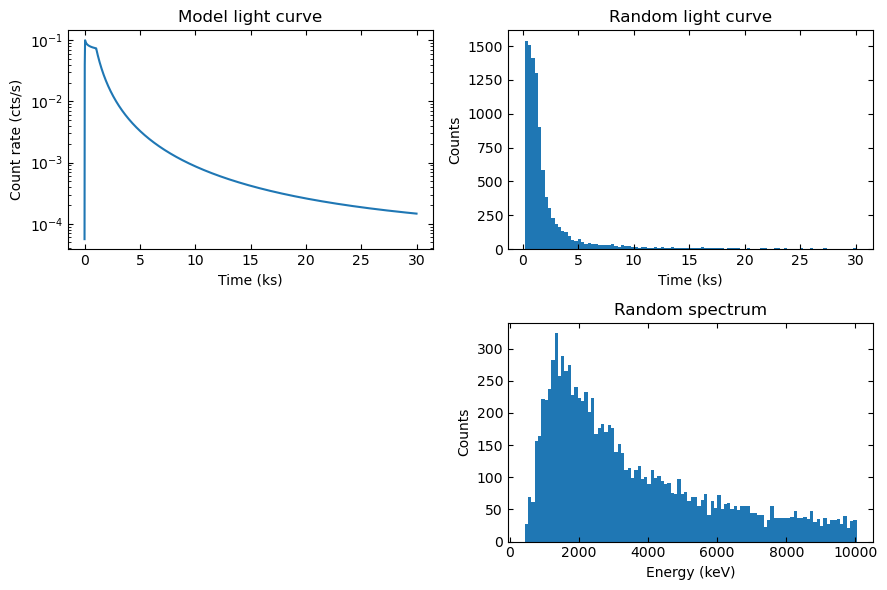

In [4]:
fig, axs = plt.subplots(2, 2, figsize=(9, 6))

# light curve
axs[0, 0].plot(t / 1000, function, label='Input light curve')
axs[0, 0].set_title('Model light curve')
axs[0, 0].set_xlabel('Time (ks)')
axs[0, 0].set_ylabel('Count rate (cts/s)')
axs[0, 0].set_yscale('log')
axs[0, 0].tick_params(direction='in', which='both', top=True, right=True)

# random light curve
axs[0, 1].hist(simulated_time / 1000, bins=100, label='Simulated light curve', align='right')
axs[0, 1].set_title('Random light curve')
axs[0, 1].set_xlabel('Time (ks)')
axs[0, 1].set_ylabel('Counts')
axs[0, 1].tick_params(direction='in', which='both', top=True, right=True)

axs[1, 0].axis('off')

# spectrum
axs[1, 1].hist(energy, bins=100, label='Random spectrum', align='right')
axs[1, 1].set_title('Random spectrum')
axs[1, 1].set_xlabel('Energy (keV)')
axs[1, 1].set_ylabel('Counts')
axs[1, 1].tick_params(direction='in', which='both', top=True, right=True)

plt.tight_layout()
plt.show()

In [11]:
# Parameters
chandra_exposure_times = np.array([
    4, 6, 8, 10, 12, 14, 16, 18, 20, 24, 28, 32, 36, 40, 44, 50
]) # possible exposure times in kiloseconds
peak_fluxes = 10**np.arange(-13.0, -12.5, 0.1) # peak fluxes in erg/cm^2/s
background_at_off_axis_angle = np.array([
    (5.6e-5, 5.0),
    (2.5e-4, 8.0),
    (7.0e-4, 11.0)
]) # (background count rate, off axis angle)
simulations = 1000 # number of simulations
# window = 20 # window size in kiloseconds

# Variable parameters
var_params = {
    'no_window': {
        'window': 9999,
        'forward': True,
        'backward': True,
        'shifted': True
    },
    'w20': {
        'window': 20,
        'forward': True,
        'backward': True,
        'shifted': True
    },
    'w20_forward': {
        'window': 20,
        'forward': True,
        'backward': False,
        'shifted': False
    },
    'w20_forward_backward': {
        'window': 20,
        'forward': True,
        'backward': True,
        'shifted': False
    },
    'w10': {
        'window': 10,
        'forward': True,
        'backward': True,
        'shifted': True
    },
    'w10_forward': {
        'window': 10,
        'forward': True,
        'backward': False,
        'shifted': False
    },
    'w10_forward_backward': {
        'window': 10,
        'forward': True,
        'backward': True,
        'shifted': False
    },
    'w30': {
        'window': 30,
        'forward': True,
        'backward': True,
        'shifted': True
    },
    'w30_forward': {
        'window': 30,
        'forward': True,
        'backward': False,
        'shifted': False
    },
    'w30_forward_backward': {
        'window': 30,
        'forward': True,
        'backward': True,
        'shifted': False
    },
}

def run_sims(window, forward, backward, shifted, name):
    detection_probabilities = {}
    for F_peak in peak_fluxes:
        print(f'log F_peak = {np.log10(F_peak):.1f}')
        detection_probabilities[str(F_peak)] = {}
        for background, theta in background_at_off_axis_angle:
            detection_probabilities[str(F_peak)][str(background)] = []
            print(f'\tbackground = {background:.2e}, theta = {theta:.1f}')
            for T_exp in chandra_exposure_times:
                print(f'\t\tT_exp = {T_exp:.1f} -> ')
                t_perf_1 = time.perf_counter()
                probability = simulate_detection_parallel_simulations(T_exp, F_peak, background, theta, simulations, window, forward, backward, shifted)
                t_perf_2 = time.perf_counter()
                print(f'\t\t\tP = {probability:.2f} ({t_perf_2 - t_perf_1:.2f} s)')
                detection_probabilities[str(F_peak)][str(background)].append(probability)

    detection_probabilities = pd.DataFrame(detection_probabilities)
    detection_probabilities.to_csv(f'json_files/detection_probabilities_{name}.csv')

for key, value in var_params.items():
    print(f'Running {key}')
    run_sims(**value, name=key)

Running no_window
log F_peak = -13.0
	background = 5.60e-05, theta = 5.0
		T_exp = 4.0 -> 
			P = 0.33 (6.44 s)
		T_exp = 6.0 -> 
			P = 0.51 (6.17 s)
		T_exp = 8.0 -> 
			P = 0.61 (6.25 s)
		T_exp = 10.0 -> 
			P = 0.70 (6.26 s)
		T_exp = 12.0 -> 
			P = 0.74 (6.26 s)
		T_exp = 14.0 -> 
			P = 0.82 (6.27 s)
		T_exp = 16.0 -> 
			P = 0.82 (6.29 s)
		T_exp = 18.0 -> 
			P = 0.85 (6.33 s)
		T_exp = 20.0 -> 
			P = 0.87 (6.38 s)
		T_exp = 24.0 -> 
			P = 0.90 (6.43 s)
		T_exp = 28.0 -> 
			P = 0.89 (6.54 s)
		T_exp = 32.0 -> 
			P = 0.91 (6.59 s)
		T_exp = 36.0 -> 
			P = 0.91 (6.81 s)
		T_exp = 40.0 -> 
			P = 0.91 (6.74 s)
		T_exp = 44.0 -> 
			P = 0.94 (6.80 s)
		T_exp = 50.0 -> 
			P = 0.93 (6.87 s)
	background = 2.50e-04, theta = 8.0
		T_exp = 4.0 -> 
			P = 0.33 (6.10 s)
		T_exp = 6.0 -> 
			P = 0.53 (6.12 s)
		T_exp = 8.0 -> 
			P = 0.62 (6.17 s)
		T_exp = 10.0 -> 
			P = 0.69 (6.23 s)
		T_exp = 12.0 -> 
			P = 0.72 (6.24 s)
		T_exp = 14.0 -> 
			P = 0.76 (6.37 s)
		T_exp = 16.0 ->

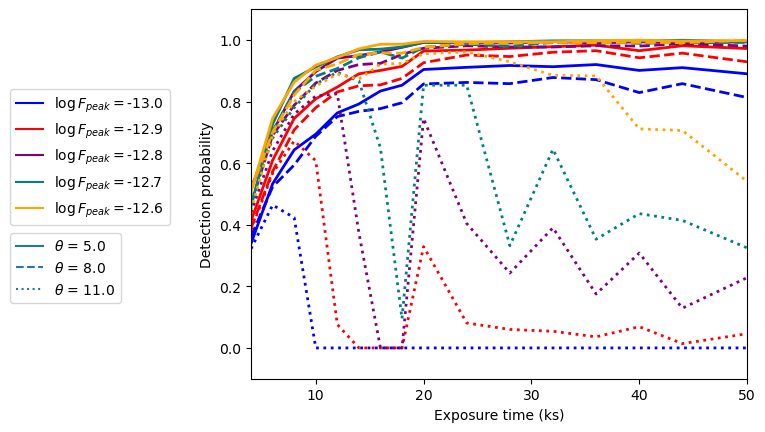

In [9]:
filename = 'detection_probabilities_w20'

detection_probabilities_plot = pd.read_csv(f'json_files/{filename}.csv', index_col=0)

fig, axs = plt.subplots()

cmap = matplotlib.colormaps['tab10']
colors = [cmap(i) for i in np.arange(0, 1, 0.1)]
colors = ['blue', 'red', 'purple', 'teal', 'orange']
line_style = ['-','--',':','-.'][0:len(background_at_off_axis_angle)]

for i, F_peak in enumerate(peak_fluxes):
    for j, (background, theta) in enumerate(background_at_off_axis_angle):
        list_of_probabilities = literal_eval(detection_probabilities_plot.at[background, str(F_peak)])
        list_of_probabilities = np.array([float(probability) for probability in list_of_probabilities])

        axs.plot(
            chandra_exposure_times, 
            list_of_probabilities,
            color=colors[i],
            linestyle=line_style[j],
            linewidth=2
        )

# axs.set_title('')

# Legend for colors and peak fluxes
color_legend = []
for i, F_peak in enumerate(peak_fluxes):
    color_legend.append(plt.Line2D([0], [0], color=colors[i], label='$\log F_{peak} = $' + f'{np.log10(F_peak):.1f}'))
legend_1 = plt.legend(handles=color_legend, bbox_to_anchor=(-0.5, 0.6), loc='center left')

# Legend for line styles and angles
line_style_legend = []
for j, (_, theta) in enumerate(background_at_off_axis_angle):
    line_style_legend.append(plt.Line2D([0], [0], linestyle=line_style[j], label=f'$\\theta$ = {theta:.1f}'))
legend_2 = plt.legend(handles=line_style_legend, bbox_to_anchor=(-0.5, 0.3), loc='center left')

axs.set_xlim(chandra_exposure_times[0], chandra_exposure_times[-1])
axs.set_ylim(-0.1, 1.1)

axs.set_xlabel('Exposure time (ks)')
axs.set_ylabel('Detection probability')

axs.add_artist(legend_1)

plt.savefig(f'plots/{filename}.pdf', bbox_inches='tight')